In [2]:
from scipy.fft import rfftfreq, irfft
import numpy as np
import matplotlib.pyplot as plt



In [13]:
# Define parameters
sample_rate = 20_000  # 20 kHz (supports up to 10 kHz)
duration = 1.0        # 1 second
N = int(sample_rate * duration)  # Total samples = 20_000
max_freq = 10_000     # Maximum frequency in the spectrum

# Generate frequency bins (one-sided)
freq_bins = rfftfreq(N, d=1/sample_rate)
for freq in freq_bins[:10]:
    print(freq)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [21]:
spectrum = np.zeros_like(freq_bins, dtype=complex)

# Add a 500 Hz tone (amplitude = 1)
spectrum[np.argmin(np.abs(freq_bins - 500))] = 1.0

# Add a 2000 Hz tone (amplitude = 0.5)
spectrum[np.argmin(np.abs(freq_bins - 2000))] = 0.5

# Add noise to other frequencies (optional)
# noise = np.random.normal(0, 0.1, len(spectrum))
# spectrum += noise

spectrum

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      shape=(10001,))

In [22]:
# Inverse FFT to generate the waveform
waveform = irfft(spectrum, n=N)

# Normalize to prevent clipping ([-1, 1] range)
waveform /= np.max(np.abs(waveform))

waveform

array([1.        , 0.92813123, 0.73704334, ..., 0.49099868, 0.73704334,
       0.92813123], shape=(20000,))

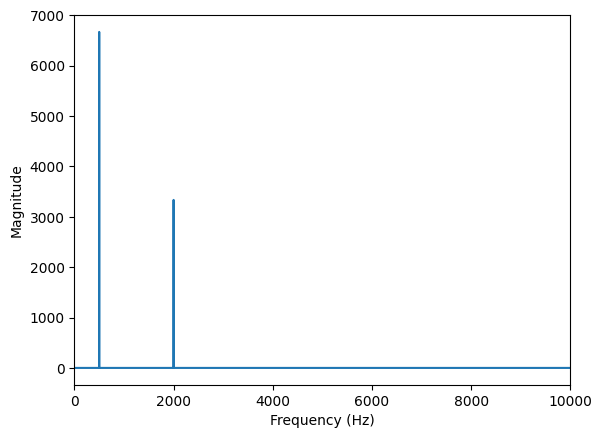

In [23]:
from scipy.fft import rfft

# Compute FFT of the generated waveform
reconstructed_spectrum = rfft(waveform)
frequencies = rfftfreq(len(waveform), d=1/sample_rate)

# Plot (requires matplotlib)
plt.plot(frequencies, np.abs(reconstructed_spectrum))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, max_freq)
plt.show()

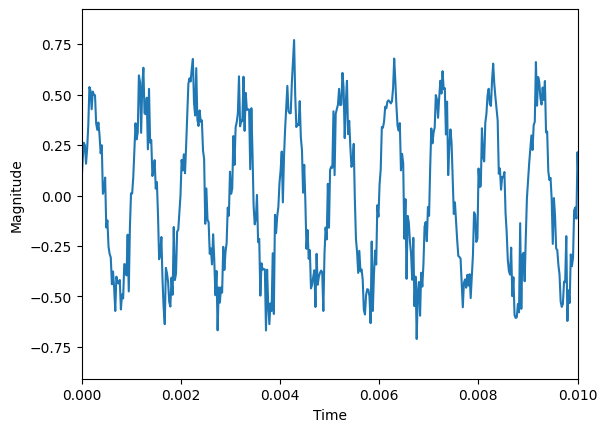

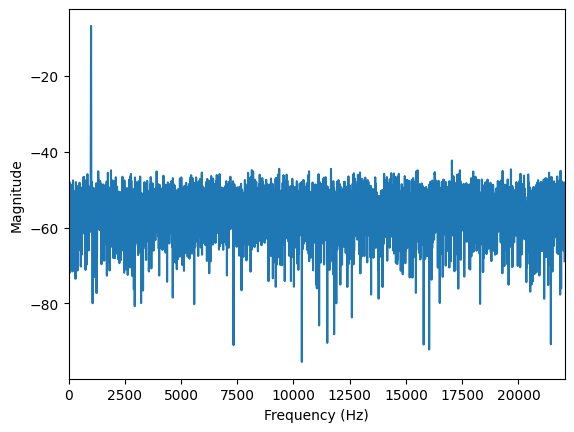

In [35]:
# Generate a test signal (1 kHz sine wave)
sample_rate = 44100  # Hz
N = 4096 * 3            # FFT size (number of samples)
t = np.arange(N) / sample_rate
signal = 0.5 * np.sin(2 * np.pi * 1000 * t)  # 1 kHz tone, amplitude=0.5

noise = np.random.normal(0, 0.1, len(signal))

signal += noise

# Plot (requires matplotlib)
plt.plot(t, signal)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.xlim(0, 0.01)
plt.show()

# Apply window function
window = np.hanning(N)
windowed_signal = signal * window
window_sum = np.sum(window)

# Compute FFT and magnitudes
fft_output = rfft(windowed_signal)
magnitudes = np.abs(fft_output)

# Normalize magnitudes
normalized_magnitudes = (2 * magnitudes) / window_sum
normalized_magnitudes[0] /= 2  # DC correction
if N % 2 == 0:
    normalized_magnitudes[-1] /= 2  # Nyquist correction

# Convert to dBFS (reference = 1.0)
dbfs = 20 * np.log10(normalized_magnitudes + 1e-12)

# Get frequency bins
frequencies = rfftfreq(N, 1 / sample_rate)

# Plot (requires matplotlib)
plt.plot(frequencies, dbfs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, sample_rate/2)
plt.show()

array([-148.53635684, -142.49266537, -142.42358391, ..., -220.5666567 ,
       -220.56750871, -225.70657092], shape=(2049,))

In [ ]:
Gerador


In [21]:
sample_rate = 22000
sample_size = 4096
ref_amplitude = 1

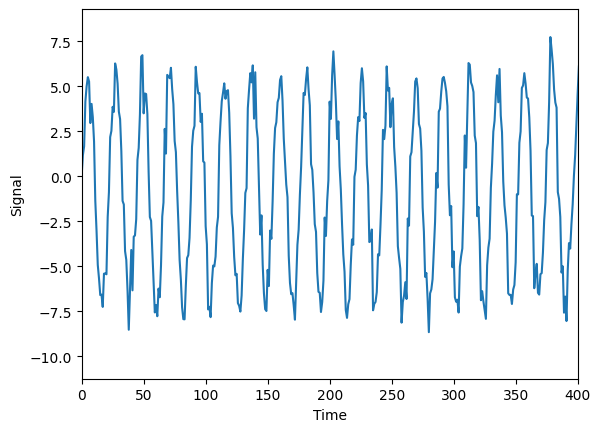

In [52]:
def generate_sound(decibels, freq, sample_rate, sample_size, ref_amplitude=1.0):
    amplitude = ref_amplitude * 10**(decibels / 20)
    t = np.arange(sample_size) / sample_rate
    signal = amplitude * np.sin(2 * np.pi * 1000 * t)  # 1 kHz tone, amplitude=0.5
    return signal


def generate_noise(decibels, sample_size, ref_amplitude=1.0):
    amplitude = ref_amplitude * 10**(decibels / 20) / 2
    noise = np.random.normal(-amplitude, +amplitude, sample_size)
    return noise

    

sound1 = generate_sound(10, 50, sample_rate, sample_size)
sound2 = generate_sound(10, 220, sample_rate, sample_size)

signal = sound1 + sound2 + generate_noise(5, sample_size)

t = np.arange(len(signal)) 
plt.plot(t, signal)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.xlim(0, 400)
plt.show()
# 



In [32]:
ref_amplitude = 1.0  # Must match the reference used in generate_sound
rms = np.sqrt(np.mean(signal ** 2))
result_db = 20 * np.log10(rms / ref_amplitude)

print(f"Resulting RMS: {rms:.4f}")
print(f"Resulting dB: {result_db:.2f} dB")

Resulting RMS: 4.6449
Resulting dB: 13.34 dB


In [29]:
freqs = np.fft.rfftfreq(len(signal), 1/sample_rate)  # Only positive frequencies
fft_magnitude = np.abs(np.fft.rfft(signal))  # Magnitude spectrum

freq_min = 10
freq_max = 100
indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]

# rms = np.sqrt(np.mean(fft_magnitude[indices] ** 2))
# db_rms = 20 * np.log10(rms / ref_amplitude)
# print(db_rms)

    
# power = np.sum(fft_magnitude[indices] ** 2)
# db_power = 10 * np.log10(power / (ref ** 2))

35.48145868915452


In [39]:
def decibels_in_band(signal, sample_rate, f_low, f_high, ref=ref_amplitude):
    freqs = np.fft.rfftfreq(len(signal), 1/sample_rate)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    indices = np.where((freqs >= f_low) & (freqs <= f_high))[0]
    
    power = np.sum(fft_magnitude[indices] ** 2)
    db_power = 10 * np.log10(power / (ref ** 2))
    
    rms = np.sqrt(np.mean(fft_magnitude[indices] ** 2))
    db_rms = 20 * np.log10(rms / ref)
    
    return db_rms, db_power

# Usage:
# signal = ... (your signal array)
# sample_rate = 44100  # for example
db_10_100Hz = decibels_in_band(signal, sample_rate, 10, 100)
# print(f"Decibels in 10–100 Hz: {db_10_100Hz:.2f} dB")
db_10_100Hz

(np.float64(35.761059607884704), np.float64(48.06554882166744))

In [58]:
def generate_sound_from_context(decibels, freq, sample_rate, sample_size, ref_amplitude=1.0):
    """
    Generates a sinusoidal signal with a given frequency and decibel level.
    (Based on GPT-4.1's provided function)
    """
    # Convert decibels to amplitude
    amplitude = ref_amplitude * 10**(decibels / 20)
    t = np.arange(sample_size) / sample_rate
    signal = amplitude * np.sin(2 * np.pi * freq * t)
    return signal

def calculate_db_per_frequency(signal, sample_rate, ref_amplitude=1.0):
    """
    Calculates the decibel level for each frequency component in a signal.

    Args:
        signal (np.array): The input time-domain signal.
        sample_rate (float): The sample rate of the signal in Hz.
        ref_amplitude (float): The reference amplitude for dB calculation.
                               This should match the reference amplitude used
                               when initially defining signal levels in dB.

    Returns:
        tuple: (frequencies, db_magnitudes)
               frequencies (np.array): Array of frequencies (up to Nyquist frequency).
               db_magnitudes (np.array): Array of corresponding dB values.
    """
    n = len(signal)

    if n < 2:
        # FFT is not meaningful for signals with less than 2 samples.
        return np.array([]), np.array([])

    # Perform FFT
    fft_result = np.fft.fft(signal)
    
    # Calculate magnitudes for the positive frequencies (one-sided spectrum)
    # We take n//2 points because the FFT output is symmetric for real inputs.
    fft_magnitudes = np.abs(fft_result[:n//2])
    
    # Scale magnitudes to represent the actual amplitudes of sine components.
    # The DC component (0 Hz) is scaled by 1/n.
    # Other frequency components are scaled by 2/n.
    amplitudes = fft_magnitudes * (2.0 / n)
    if n > 0: # Ensure n is not zero before division
        amplitudes[0] = fft_magnitudes[0] / n # Correct scaling for DC component

    # Create frequency axis corresponding to the scaled magnitudes
    frequencies = np.fft.fftfreq(n, d=1.0/sample_rate)[:n//2]
    
    # Convert amplitudes to dB.
    # A very small number (epsilon) is added to amplitudes to prevent log10(0) errors,
    # which would result in -infinity.
    epsilon = 1e-12 
    db_magnitudes = 20 * np.log10(np.maximum(amplitudes, epsilon) / ref_amplitude)
    
    return frequencies, db_magnitudes

# Define signal parameters
sample_rate = 22000  # samples per second
duration = 1.0       # seconds
sample_size = int(sample_rate * duration)
ref_amplitude = 1.0  # Reference amplitude for dB calculations

# Generate a few signals with known frequencies and dB levels
# One signal within the 10-100 Hz range, one outside
signal_50hz = generate_sound_from_context(decibels=6, freq=50, 
                                          sample_rate=sample_rate, 
                                          sample_size=sample_size, 
                                          ref_amplitude=ref_amplitude)

signal_75hz = generate_sound_from_context(decibels=10, freq=75, 
                                          sample_rate=sample_rate, 
                                          sample_size=sample_size, 
                                          ref_amplitude=ref_amplitude)

signal_150hz = generate_sound_from_context(decibels=12, freq=150, 
                                           sample_rate=sample_rate, 
                                           sample_size=sample_size, 
                                           ref_amplitude=ref_amplitude)

# Sum the signals to create a composite signal
resultant_signal = signal_50hz + signal_75hz + signal_150hz + generate_noise(10, len(signal_150hz))

# Calculate dB per frequency for the resultant signal
all_frequencies, all_db_values = calculate_db_per_frequency(resultant_signal, 
                                                            sample_rate, 
                                                            ref_amplitude)

# Now, filter for the 10 Hz to 100 Hz range
desired_min_freq = 10.0
desired_max_freq = 100.0

# Create a boolean mask to select frequencies within the desired range
frequency_mask = (all_frequencies >= desired_min_freq) & \
                 (all_frequencies <= desired_max_freq)

# Apply the mask to get frequencies and dB values only in that range
frequencies_in_range = all_frequencies[frequency_mask]
db_values_in_range = all_db_values[frequency_mask]

# Output the results for the specified range
print(f"Decibels per frequency from {desired_min_freq} Hz to {desired_max_freq} Hz:")
if frequencies_in_range.size > 0:
    for f, db in zip(frequencies_in_range, db_values_in_range):
        # Let's only print significant values to avoid a long list of noise floor values
        if db > -40: # You can adjust this threshold
            print(f"Frequency: {f:7.2f} Hz, dB: {db:6.2f} dB")
else:
    print("No frequency components found in the specified range above -40 dB.")

# For verification, let's check the dB values at the original frequencies
print("\n--- Verification of specific frequencies ---")
idx_50hz = np.argmin(np.abs(all_frequencies - 50))
print(f"At {all_frequencies[idx_50hz]:.2f} Hz (expected 50 Hz at -6 dB): {all_db_values[idx_50hz]:.2f} dB")

idx_75hz = np.argmin(np.abs(all_frequencies - 75))
print(f"At {all_frequencies[idx_75hz]:.2f} Hz (expected 75 Hz at -10 dB): {all_db_values[idx_75hz]:.2f} dB")

idx_150hz = np.argmin(np.abs(all_frequencies - 150)) # This is outside the 10-100Hz range
print(f"At {all_frequencies[idx_150hz]:.2f} Hz (expected 150 Hz at -12 dB): {all_db_values[idx_150hz]:.2f} dB")


Decibels per frequency from 10.0 Hz to 100.0 Hz:
Frequency:   10.00 Hz, dB: -33.31 dB
Frequency:   12.00 Hz, dB: -38.87 dB
Frequency:   13.00 Hz, dB: -31.65 dB
Frequency:   14.00 Hz, dB: -37.17 dB
Frequency:   15.00 Hz, dB: -28.49 dB
Frequency:   16.00 Hz, dB: -30.47 dB
Frequency:   18.00 Hz, dB: -27.10 dB
Frequency:   22.00 Hz, dB: -30.07 dB
Frequency:   23.00 Hz, dB: -37.03 dB
Frequency:   24.00 Hz, dB: -29.39 dB
Frequency:   25.00 Hz, dB: -36.26 dB
Frequency:   27.00 Hz, dB: -39.02 dB
Frequency:   28.00 Hz, dB: -32.08 dB
Frequency:   29.00 Hz, dB: -37.71 dB
Frequency:   30.00 Hz, dB: -36.86 dB
Frequency:   32.00 Hz, dB: -35.90 dB
Frequency:   34.00 Hz, dB: -34.74 dB
Frequency:   35.00 Hz, dB: -30.26 dB
Frequency:   36.00 Hz, dB: -32.99 dB
Frequency:   37.00 Hz, dB: -30.82 dB
Frequency:   38.00 Hz, dB: -30.75 dB
Frequency:   39.00 Hz, dB: -38.48 dB
Frequency:   42.00 Hz, dB: -29.58 dB
Frequency:   43.00 Hz, dB: -35.08 dB
Frequency:   44.00 Hz, dB: -37.23 dB
Frequency:   45.00 Hz, dB:

In [43]:
all_db_values

array([-240., -240., -240., ..., -240., -240., -240.], shape=(22050,))

In [47]:
np.argmin(np.abs(all_frequencies - 50))

np.int64(50)

In [51]:
all_db_values[49]


np.float64(-240.0)